In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt 
#import lightgbm as lgb
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from pandas import pivot_table

import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'

## Part 1. Dataset and features description

###### This dataset contains the history of customer transactions for 3 months of preferential use of the banking product.

In the test file.the csv contains lines of c 518375 transactions made by the clients of the Bank. The cl_id column contains the internal client id. For each unique cl_id, you should predict whether the client will continue to use the product (target_flag). A value of 0 indicates failure and a value of 1 indicates continued use.

| Column        | Transcription                         |
|---------------|---------------------------------------|
|PERIOD         |transaction month                      |       
|cl_id          |client id                              |
|MCC            |seller category code                   |
|channel_type   |customer engagement channel            |
|currency       |currency                               |
|TRDATETIME     |transaction date/time                  |
|amount         |transaction amount                     |
|trx_category   |type of transaction POS payment through
|               |the POS terminal, C2C_OUT – transfer 
|               |(outgoing payment), C2C_IN – card      |
|               |transaction (incoming payment), DEPOSIT| 
|               |card in the ATM, WD_ATM_PARTNER – cash |
|               | withdrawals at ATMs partners
|target_flag    |will the customer continue to use the product after the grace period (1/0) (target)
|target_sum     | the amount of the transaction kind of POS for the three future months (target)

In [405]:
#raw_df = pd.read_csv('Rosbankk.csv',error_bad_lines=False)
#
#raw_df.to_csv('rosbank_train.csv')
#test = pd.read_csv('rosbank_test.csv',error_bad_lines=False)
raw_df = pd.read_csv('Rosbankk.csv',error_bad_lines=False)

In [238]:
#raw_df = pd.read_csv('rosbank_train.csv',error_bad_lines=False)
#del raw_df['Unnamed: 0']

In [406]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [407]:
raw_df.info()
raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


,cl_id,MCC,currency,amount,target_flag,target_sum
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000,4.905130e+05
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588,1.627345e+05
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148,1.474097e+06
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000,0.000000e+00
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000,0.000000e+00
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000,2.491009e+04
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000,1.516193e+05
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000,4.606578e+07


In [418]:
print( 'Number of unique clients =',raw_df['cl_id'].nunique())
print ('At channel_type column there are ', round(100*(len(raw_df[raw_df['channel_type'].isna()]) / len(raw_df)),1), '% of empty cells')

Number of unique clients = 5000
At channel_type column there are  0.0 % of empty cells


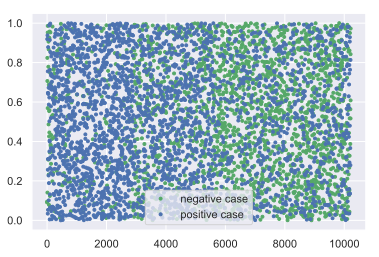

In [419]:
X = raw_df[['cl_id','target_flag']].groupby('cl_id').agg('max').reset_index()
ind = X['target_flag']==0
plt.plot(X['cl_id'][ind], np.random.rand(np.sum(ind)), 'g.', label='negative case')
ind = X['target_flag']==1
plt.plot(X['cl_id'][ind], np.random.rand(np.sum(ind)), 'b.', label='positive case')
plt.legend()

In [817]:
days_usage['cl_id'] =days_usage.index

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'cl_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


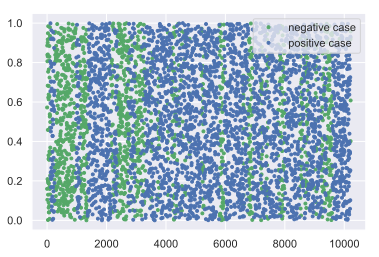

In [818]:
y = days_usage[['cl_id','target_flag']].groupby('cl_id').agg('max').reset_index()
ind = y['target_flag']==0
plt.plot(y['cl_id'][ind], np.random.rand(np.sum(ind)), 'g.', label='negative case')
ind = y['target_flag']==1
plt.plot(y['cl_id'][ind], np.random.rand(np.sum(ind)), 'b.', label='positive case')
plt.legend()

# From dataset we see, that:
MCC is not int number, it have to be categorial data(we will find descriptions in the Internet);  Currency should be also categorial data

In total there are 490513 transactions for 3 month, by made 5000 clients. In general it's about 
98 transactions by 1 client for 3 month of using card.

Time period is from to 

In [408]:
#Trere are some channel_type are empty. Let's fill them by 'type0' 
raw_df.channel_type.fillna('type6', inplace = True)

In [ ]:
from datetime import datetime, date, time

raw_df['PERIOD'] = raw_df['PERIOD'].apply(pd.to_datetime)

# Creating separate cols for yr, month,...
raw_df['Year'] = raw_df.TRDATETIME.str[5:7]
raw_df['Month'] = raw_df.TRDATETIME.str[2:5]
raw_df['Date'] = raw_df.TRDATETIME.str[0:2]
raw_df['Hour'] = raw_df.TRDATETIME.str[8:10]

# Replace month with ints
raw_df.Month = raw_df.Month.replace(to_replace=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN','JUL','AUG',\
                                                'SEP','OCT','NOV','DEC' ], value=[1,2,3,4,5,6,7,8,9,10,11,12])

raw_df.Year = raw_df.Year.apply(pd.to_numeric)
raw_df.Date = raw_df.Date.apply(pd.to_numeric)
raw_df.Month= raw_df.Month.apply(pd.to_numeric)
raw_df.Hour = raw_df.Hour.apply(pd.to_numeric)
raw_df.Year = raw_df.Year + 2000

def to_date(row):    
    return date(row[10], row[11], row[12])
raw_df['DateFormat'] = raw_df.apply(to_date, axis=1)

def Quater(row):
    if row['Month']in [1, 2, 3]:
        return 1
    if row['Month']in [4, 5, 6]:
        return 2   
    if row['Month']in [7, 8, 9]:
        return 3 
    if row['Month']in [10, 11, 12]:
        return 4
raw_df['quater_of_year'] = raw_df.apply(Quater, axis = 1)

raw_df['weekend'] = raw_df['DateFormat'].astype('datetime64[ns]')
raw_df['weekend'] = ((raw_df.weekend.dt.dayofweek) // 5 ==1).astype(float)

In [422]:
from currency_converter import CurrencyConverter

converter = CurrencyConverter(fallback_on_missing_rate=True, fallback_on_wrong_date=True)
converter_currencies = converter.currencies

def convert_to_rub(amount, currency, day):
    if currency == 'RUB':
        return amount
    else:
        if currency in converter_currencies:
            return converter.convert(amount, currency, 'RUB', date = day)
        else: amount     
        return amount
    
    
def cash_in_out(raw):
    if raw['trx_category'] == 'POS':
        return raw['amount']*(-1)
    if raw['trx_category'] == 'C2C_OUT':
        return raw['amount']*(-1)
    if raw['trx_category'] == 'WD_ATM_PARTNER':
        return raw['amount']*(-1)
    if raw['trx_category'] == 'WD_ATM_ROS':
        return raw['amount']*(-1)    
    else:
        return raw['amount']
    
raw_df['amount'] = raw_df.apply(lambda x: convert_to_rub(x['amount'], x['currency'], x['DateFormat']), axis = 1)
raw_df['cash_in_out'] = raw_df.apply(cash_in_out, axis=1)

raw_df.to_csv('rosbank_train.csv')

In [749]:
raw_df =pd.read_csv('rosbank_train.csv')

In [750]:
max_date = raw_df[['cl_id', 'DateFormat']].groupby('cl_id').max().reset_index()
max_date.columns = ['cl_id', 'last_action']

raw_df = pd.merge(raw_df, max_date, how='left', on='cl_id')

In [751]:

raw_df['last_action'] = pd.to_datetime(raw_df['last_action'])

raw_df['last_14_days'] = raw_df['last_action'] - timedelta(days=14)
raw_df['last_30_days'] = raw_df['last_action'] - timedelta(days=30)

raw_df['DateFormat'] = pd.to_datetime(raw_df['DateFormat'])
raw_df['last_14_days']= pd.to_datetime(raw_df['last_14_days'])
raw_df['last_30_days'] = pd.to_datetime(raw_df['last_30_days'])

In [752]:
def last_14_days1(row):
    if row['DateFormat']>=row['last_14_days']:
        return 1

def last_30_days1(row):
    if row['DateFormat']>=row['last_30_days']:
        return 1
    
raw_df['last_14_days'] = raw_df.apply(last_14_days1, axis=1)
raw_df['last_30_days'] = raw_df.apply(last_30_days1, axis=1)

raw_df=pd.read_csv('rosbank_train.csv')

In [753]:
raw_df.head()

,Unnamed: 0,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,Year,Month,Date,Hour,DateFormat,weekend,cash_in_out,quater_of_year,last_action,last_14_days,last_30_days
0,0,2017-01-10,0,5200,type0,810,21OCT17:00:00:00,5023.0,POS,0,0.0,2017,10,21,0,2017-10-21,1.0,-5023.0,4,2017-12-05,NaN,NaN
1,1,2017-01-10,0,6011,type0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,2017,10,12,12,2017-10-12,0.0,20000.0,4,2017-12-05,NaN,NaN
2,2,2017-01-12,0,5921,type0,810,05DEC17:00:00:00,767.0,POS,0,0.0,2017,12,5,0,2017-12-05,0.0,-767.0,4,2017-12-05,1.0,1.0
3,3,2017-01-10,0,5411,type0,810,21OCT17:00:00:00,2031.0,POS,0,0.0,2017,10,21,0,2017-10-21,1.0,-2031.0,4,2017-12-05,NaN,NaN
4,4,2017-01-10,0,6012,type0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2017,10,24,13,2017-10-24,0.0,-36562.0,4,2017-12-05,NaN,NaN


In [754]:
mcc_codes = pd.read_excel('mcc_codes1.xlsx')
mcc_codes.columns = ['MCC', 'Name' , 'Group']

raw_df = pd.merge(raw_df, mcc_codes, 'left', on=['MCC'])

In [755]:
mcc_codes.head()

,MCC,Name,Group
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельскохозяйственные кооперативы,Контрактные услуги
2,780,Услуги садоводства и ландшафтного дизайна,Контрактные услуги
3,1520,Генеральные подрядчики – жилое и коммерческое ...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",Контрактные услуги


In [787]:
raw_df.head()

,Unnamed: 0,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,Year,Month,Date,Hour,DateFormat,weekend,cash_in_out,quater_of_year,last_action,last_14_days,last_30_days,Name,Group,cashback
0,0,2017-01-10,0,5200,type0,810,21OCT17:00:00:00,5023.0,POS,0,0.0,2017,10,21,0,2017-10-21,1.0,-5023.0,4,2017-12-05,NaN,NaN,Товары для дома,Розничные магазины,100.46
1,1,2017-01-10,0,6011,type0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,2017,10,12,12,2017-10-12,0.0,20000.0,4,2017-12-05,NaN,NaN,Финансовые учреждения – снятие наличности авто...,Поставщик услуг,NaN
2,2,2017-01-12,0,5921,type0,810,05DEC17:00:00:00,767.0,POS,0,0.0,2017,12,5,0,2017-12-05,0.0,-767.0,4,2017-12-05,1.0,1.0,Магазины с продажей спиртных напитков навынос,Различные магазины,15.34
3,3,2017-01-10,0,5411,type0,810,21OCT17:00:00:00,2031.0,POS,0,0.0,2017,10,21,0,2017-10-21,1.0,-2031.0,4,2017-12-05,NaN,NaN,"Бакалейные магазины, супермаркеты",Розничные магазины,40.62
4,4,2017-01-10,0,6012,type0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2017,10,24,13,2017-10-24,0.0,-36562.0,4,2017-12-05,NaN,NaN,Финансовые учреждения – торговля и услуги,Поставщик услуг,NaN


In [759]:
def cashback(raw):
    if raw['trx_category'] == 'POS':
        return raw['amount']*0.02
raw_df['cashback'] = raw_df.apply(cashback, axis=1)

In [786]:
raw_df.to_csv('rosbank_train1.csv')

In [764]:
def days_in_use(x):
    return (np.max(x) - np.min(x)).days

days_usage = raw_df[['cl_id','DateFormat']].groupby('cl_id').agg(days_in_use)

In [772]:
def days_in_use(x):
    return (np.max(x) - np.min(x)).days

days_usage = raw_df[['cl_id','DateFormat']].groupby('cl_id').agg(days_in_use)

days_usage['target_flag'] = raw_df['target_flag']

max_date = raw_df[['cl_id', 'DateFormat']].groupby('cl_id').max()
days_usage['days_from_end_period']= (max(raw_df['DateFormat']) - max_date['DateFormat']).dt.days


num_trans_total = raw_df[['cl_id','DateFormat']].groupby('cl_id').agg('count').reset_index()
num_trans_total.columns = ['cl_id', 'num_trans_total']
num_trans_total.index=num_trans_total.cl_id
days_usage['Num_trans_total'] = num_trans_total.num_trans_total

num_trans_month = raw_df[['cl_id','Month']].groupby('cl_id').agg('mean').reset_index()
num_trans_month.columns = ['cl_id', 'num_trans_month']
num_trans_month.index=num_trans_month.cl_id
days_usage['Num_trans_month'] = num_trans_month.num_trans_month


balance_on_end_of_period = raw_df[['cl_id', 'cash_in_out']].groupby('cl_id').sum().reset_index()
balance_on_end_of_period.columns=['cl_id', 'balance_on_end_of_period']
balance_on_end_of_period.index=balance_on_end_of_period.cl_id
days_usage['balance_on_end_of_period'] = balance_on_end_of_period.balance_on_end_of_period

cashback = raw_df[['cl_id', 'cashback']].groupby('cl_id').sum().reset_index()
cashback.columns=['cl_id', 'cashback']
cashback.index=cashback.cl_id
days_usage['cashback'] = cashback.cashback


spent_trx_category = raw_df[['cl_id', 'trx_category' ,'amount']].groupby(['cl_id', 'trx_category']).sum().\
                                                                                        unstack().reset_index()
spent_trx_category=spent_trx_category.fillna(0)
spent_trx_category.columns = ['cl_id', 'BACK_TRX', 'C2C_IN', 'C2C_OUT', 'CASH_ADV', 'CAT', 'DEPOSIT',
       'POS', 'WD_ATM_OTHER', 'WD_ATM_PARTNER', 'WD_ATM_ROS'] 
spent_trx_category.index= spent_trx_category.cl_id

days_usage[['BACK_TRX', 'C2C_IN', 'C2C_OUT', 'CASH_ADV', 'CAT', 'DEPOSIT',
       'POS', 'WD_ATM_OTHER', 'WD_ATM_PARTNER', 'WD_ATM_ROS']] = spent_trx_category[['BACK_TRX', 'C2C_IN', 'C2C_OUT',\
                                 'CASH_ADV', 'CAT', 'DEPOSIT','POS', 'WD_ATM_OTHER', 'WD_ATM_PARTNER', 'WD_ATM_ROS']]

quntity_of_mcc = raw_df[['cl_id','MCC']].groupby(['cl_id','MCC']).apply(lambda x: x.count()).unstack().\
                                                                                        max(axis=1).reset_index()
quntity_of_mcc.columns=['cl_id', 'quntity_of_mcc']
quntity_of_mcc.index= quntity_of_mcc.cl_id
days_usage['quntity_of_mcc']=quntity_of_mcc.quntity_of_mcc

multy_currency =raw_df[['cl_id', 'currency']].groupby(['cl_id', 'currency']).first().reset_index()
multy_currency = multy_currency.groupby(['cl_id']).count()
#multy_currency.index= multy_currency.cl_id

days_usage['multy_currency']=multy_currency.currency


last_14_days=raw_df[['cl_id', 'last_14_days']].groupby(['cl_id']).sum()
last_30_days=raw_df[['cl_id', 'last_30_days']].groupby(['cl_id']).sum()

days_usage['last_14_days']=last_14_days.last_14_days
days_usage['last_30_days']=last_30_days.last_30_days


group_mcc = pivot_table(raw_df, values='cash_in_out', 
                    index=['cl_id'], columns=['Group'], aggfunc=lambda cash_in_out: len(cash_in_out.unique())).fillna(0)
group_mcc2 = pivot_table(raw_df, values='cash_in_out', 
                    index=['cl_id'], columns=['Group'], aggfunc=np.sum).fillna(0)

mcc = pd.merge(group_mcc, group_mcc2, 'left', on=days_usage.index)

mcc.index=mcc.key_0
days_usage[mcc.columns]= mcc
del days_usage['key_0']

trx_category = raw_df[['cl_id','trx_category', 'cash_in_out']].groupby(['cl_id','trx_category']).sum()\
                                                                                                .unstack()
days_usage[trx_category.columns]=trx_category

In [814]:
days_usage.to_csv('days_usage.csv')

In [784]:
days_usage['multy_currency']=multy_currency.currency

sns.boxplot(x='days_in_use', data=days_usage);

print('days_in_use median = ',days_usage.days_in_use.median())
#print('days_in_use median = ',days_usage.num_trans.median())
days_usage.describe()

In [820]:
raw_df.head()

,Unnamed: 0,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,Year,Month,Date,Hour,DateFormat,weekend,cash_in_out,quater_of_year,last_action,last_14_days,last_30_days,Name,Group,cashback
0,0,2017-01-10,0,5200,type0,810,21OCT17:00:00:00,5023.0,POS,0,0.0,2017,10,21,0,2017-10-21,1.0,-5023.0,4,2017-12-05,NaN,NaN,Товары для дома,Розничные магазины,100.46
1,1,2017-01-10,0,6011,type0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,2017,10,12,12,2017-10-12,0.0,20000.0,4,2017-12-05,NaN,NaN,Финансовые учреждения – снятие наличности авто...,Поставщик услуг,NaN
2,2,2017-01-12,0,5921,type0,810,05DEC17:00:00:00,767.0,POS,0,0.0,2017,12,5,0,2017-12-05,0.0,-767.0,4,2017-12-05,1.0,1.0,Магазины с продажей спиртных напитков навынос,Различные магазины,15.34
3,3,2017-01-10,0,5411,type0,810,21OCT17:00:00:00,2031.0,POS,0,0.0,2017,10,21,0,2017-10-21,1.0,-2031.0,4,2017-12-05,NaN,NaN,"Бакалейные магазины, супермаркеты",Розничные магазины,40.62
4,4,2017-01-10,0,6012,type0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2017,10,24,13,2017-10-24,0.0,-36562.0,4,2017-12-05,NaN,NaN,Финансовые учреждения – торговля и услуги,Поставщик услуг,NaN


In [819]:
days_usage.corr()

,DateFormat,target_flag,days_from_end_period,Num_trans_total,Num_trans_month,balance_on_end_of_period,cashback,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS,quntity_of_mcc,multy_currency,"Авиалинии, авиакомпании_x",Автомобили и транспортные средства_x,Аренда автомобилей_x,Бизнес услуги_x,Государственные услуги_x,Коммунальные и кабельные услуги_x,Контрактные услуги_x,Личные услуги_x,Магазины одежды_x,Оптовые поставщики и производители_x,Отели и мотели_x,Поставщик услуг_x,Продажи по почте/телефону_x,Профессиональные услуги_x,Развлечения_x,Различные магазины_x,Ремонтные услуги_x,Розничные магазины_x,Транспорт_x,Членские организации_x,"Авиалинии, авиакомпании_y",Автомобили и транспортные средства_y,Аренда автомобилей_y,Бизнес услуги_y,Государственные услуги_y,Коммунальные и кабельные услуги_y,Контрактные услуги_y,Личные услуги_y,Магазины одежды_y,Оптовые поставщики и производители_y,Отели и мотели_y,Поставщик услуг_y,Продажи по почте/телефону_y,Профессиональные услуги_y,Развлечения_y,Различные магазины_y,Ремонтные услуги_y,Розничные магазины_y,Транспорт_y,Членские организации_y,"(cash_in_out, BACK_TRX)","(cash_in_out, C2C_IN)","(cash_in_out, C2C_OUT)","(cash_in_out, CASH_ADV)","(cash_in_out, CAT)","(cash_in_out, DEPOSIT)","(cash_in_out, POS)","(cash_in_out, WD_ATM_OTHER)","(cash_in_out, WD_ATM_PARTNER)","(cash_in_out, WD_ATM_ROS)",cl_id
DateFormat,1.000000,-0.049784,-0.263345,0.275041,0.275041,-0.063750,0.037946,-0.007204,0.052699,0.091888,0.086678,0.043351,0.124194,0.037946,0.021981,-0.019674,0.151227,0.259320,0.073941,0.026769,0.137709,0.007134,0.069125,0.059788,0.095030,0.036045,0.082856,0.129795,0.042754,0.046657,0.263246,0.032833,0.095618,0.097077,0.202423,0.053299,0.207570,0.071845,0.025032,-0.011152,-0.057918,-0.001251,-0.015266,-0.046692,-0.006970,-0.015769,-0.028454,-0.055098,-0.016088,-0.008686,-0.043624,-0.013927,-0.015393,-0.012727,-0.039846,-0.013712,-0.091055,-0.010969,-0.008820,-0.083230,0.033335,-0.089910,0.706307,0.120761,0.147530,-0.037946,0.022454,0.116859,-0.150870,-0.123880
target_flag,-0.049784,1.000000,0.078487,-0.058518,-0.058518,0.017825,-0.014784,0.015743,-0.023992,-0.011501,-0.020316,-0.016601,0.075794,-0.014784,-0.021435,0.017452,-0.005390,-0.046714,-0.039448,0.012341,-0.012701,0.012317,0.000989,-0.003476,-0.021675,0.026534,-0.031034,-0.037857,-0.002092,-0.009281,-0.036769,0.016410,-0.012139,-0.035543,-0.065368,0.019868,-0.042386,-0.014846,0.004021,-0.006204,-0.011783,0.001454,-0.026317,0.021496,0.023017,-0.018974,0.023990,0.016654,-0.004263,-0.009152,0.003629,0.004115,0.019282,-0.000852,0.031706,-0.021773,0.045327,0.018923,0.011986,0.027533,-0.031047,-0.000379,-0.314890,-0.028440,0.044009,0.014784,-0.025726,-0.084403,-0.007438,0.285344
days_from_end_period,-0.263345,0.078487,1.000000,-0.111626,-0.111626,0.023404,-0.013550,0.031143,-0.057625,-0.105223,-0.028968,-0.006768,-0.000500,-0.013550,0.003010,0.044332,-0.039495,-0.073235,-0.082238,0.002874,-0.042208,-0.011534,0.026502,-0.069143,-0.023568,-0.020310,-0.060703,-0.073435,-0.007076,-0.080583,-0.109679,0.063879,-0.035214,-0.006509,-0.106401,-0.028036,-0.044846,-0.063966,-0.014853,-0.013972,0.019387,0.023902,-0.076068,0.063937,-0.012330,0.001345,0.011889,0.054522,0.002174,0.025779,0.015720,-0.039254,-0.002883,0.019964,-0.004024,0.016443,0.002862,-0.010747,-0.006707,0.056114,-0.092231,0.117110,-0.267840,-0.007837,-0.095411,0.013550,0.037685,-0.139529,0.015307,0.330959
Num_trans_total,0.275041,-0.058518,-0.111626,1.000000,1.000000,-0.032834,0.064650,0.003345,0.123112,0.076457,-0.003252,0.001172,0.175331,0.064650,0.003889,-0.004823,0.016675,0.833273,0.168471,0.032390,0.471395,0.042011,0.288653,0.216212,0.256476,0.073671,0.287592,0.438729,0.146474,0.223041,0.491741,0.168565,0.291900,0.402557,0.846848,0.235635,0.818258,0.371048,0.090223,-0.032926,-0.163253,-0.001483,-0.016240,-0.076429,-0.006027,-0.006157,-0.060974,-0.144654,-0.022118,-0.009547,0.047639,-0.046759,-0.006093,-0.032945,-0.072987,-0.050868,-0.198343,-0.0

In [ ]:
сделать группировки по 
weekend
quater_of_year
last_action
last_14_days
last_30_days 

далее выбрать из признаков категориальные и сделать WOE и counts

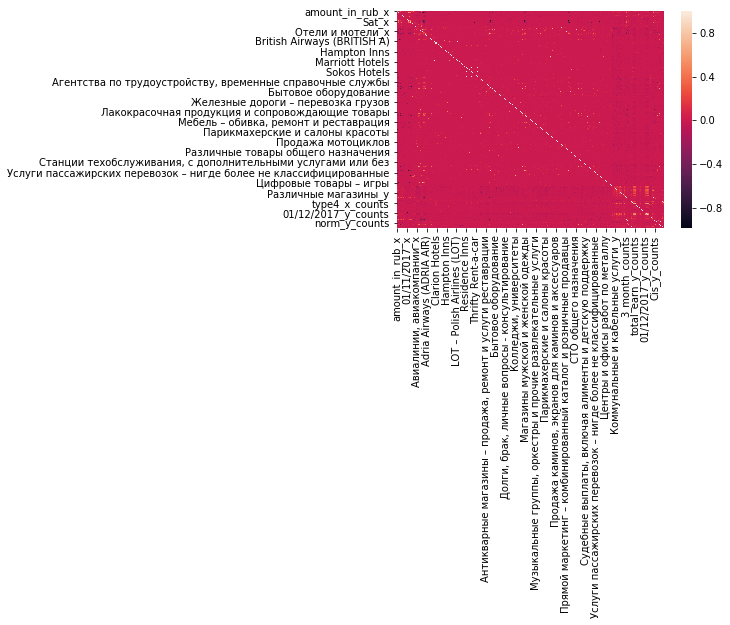

In [726]:
import seaborn as sns
sns.heatmap(x_train1.corr());

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data_train, data_train.target_flag):
    d_train = data_train.iloc[train_index]
    d_test = data_train.iloc[test_index]
    
    y_train = data_train['target_flag'].iloc[train_index]
    y_test = data_train['target_flag'].iloc[test_index]

In [ ]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

columns_to_get_counts = ['total_usage', 'POS_usage', '1_month', '2_month', '3_month', '60_days', '7_days',
  'Asia', 'CIS', 'Cis', 'Russia', 'asia', 'cheap', 'expencive', 'norm']
    
for col_get_prob in columns_to_get_counts:
    data_train, data_test = get_counts(data_train, data_test, col_get_prob, 'target_flag')

def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series +0.001).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

for col_get_prob in columns_to_get_counts:
    data_train, data_test = get_woe_v1(data_train, data_test, col_get_prob, 'target_flag')

# Predictions

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns=x_test.columns)
X_scaled_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns=x_train.columns)
x_test1=X_scaled_test
x_train1=X_scaled_train
del x_train1['index']
del x_test1['index']

In [708]:
import xgboost
from sklearn.metrics import roc_auc_score, roc_curve
xgb = xgboost.XGBClassifier(learning_rate=0.01, max_depth=10, n_jobs=-1)
xgb.fit(x_train1_l1, y_train)
y_train_predict = xgb.predict_proba(x_train1_l1)[:, 1]
y_test_predict = xgb.predict_proba(x_test1_l1)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
#print("Test: ", roc_auc_test)

Train:  0.94


In [709]:
from sklearn.ensemble import AdaBoostClassifier, 
from sklearn.tree import DecisionTreeClassifier
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, max_features=0.8),
                             n_estimators=20, learning_rate=0.03)

clf_ada.fit(x_train1, y_train)
y_pred_ada_test = clf_ada.predict_proba(x_test1)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_ada_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.95


In [710]:
from sklearn.ensemble import  GradientBoostingClassifier
clf_gbm = GradientBoostingClassifier(max_depth=12, min_samples_leaf=10, n_estimators=20, learning_rate=0.05, 
                                     subsample=0.8, max_features=0.8, verbose=2)

clf_gbm.fit(x_train1, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(x_test1)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(x_train1)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_pred_gbm_train), 2)
#roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3341           0.0254            7.53s
         2           1.2932           0.0182            7.28s
         3           1.2591           0.0174            6.82s
         4           1.2224           0.0148            6.39s
         5           1.1992           0.0162            6.14s
         6           1.1707           0.0128            5.65s
         7           1.1447           0.0124            5.17s
         8           1.1254           0.0101            4.77s
         9           1.1025           0.0099            4.36s
        10           1.0839           0.0045            3.98s
        11           1.0638           0.0074            3.58s
        12           1.0379           0.0064            3.21s
        13           1.0152           0.0043            2.84s
        14           1.0070           0.0055            2.40s
        15           0.9859           0.0047            2.00s
       

In [723]:
from sklearn.feature_selection import SelectFromModel
select =SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
select.fit(x_train1,y_train)
x_train1_l1=select.transform(x_train1)
x_test1_l1=select.transform(x_test1)
score=LogisticRegression().fit(x_train1_l1,y_train).score(x_train1_l1,y_train)
print(score)

0.7502


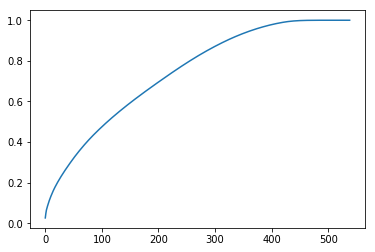

In [713]:
pca = PCA()
pca.fit(x_train1)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = np.cumsum(pca.explained_variance_ratio_)
#e = pd.DataFrame(pca.components_,columns=x_train1.columns)
plt.plot(cumsum);

In [669]:
TCnm идея построить прогннозы по временным рядам с помощью Prophet и результаты включить в модель

array([0.679955  , 0.80270904, 0.22664922, ..., 0.93753314, 0.80796003,
       0.87948   ], dtype=float32)

from fbprophet import Prophet

for i in raw_df.cl_id.unique():
    df = raw_df[['TRDATETIME', 'amount']][raw_df['cl_id'] == i]
    df.columns=['ds', 'y']
    

df = raw_df[['TRDATETIME', 'amount']][raw_df['cl_id'] == 10]
df.columns=['ds', 'y']

m = Prophet()
m.fit(df)

#prediction_size = 2
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)


def make_predictions (col):    

    m1=dfq[['date', col]]
    m1.columns=['ds', 'y']

    promo = pd.DataFrame({
                          'holiday': 'promo',
                          'ds': pd.to_datetime(list(df2[df2[col]>0]['date']) + list(df3[df3[col]>0]['date'])),
                          'lower_window': 0,
                          'upper_window': 1})
    

    m = Prophet(holidays=promo)
    m.fit(m1)
    future = m.make_future_dataframe(periods=729)
    forecast = m.predict(future)
    deploy[col] = forecast[forecast['ds']>='2016-01-01']['yhat'].reset_index()['yhat']
    
    return deploy[col]